In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [6]:
!pip --version

pip 24.0 from /Users/yerin/.pyenv/versions/3.7.17/lib/python3.7/site-packages/pip (python 3.7)


In [7]:
!pip3 install tensorflow==2.6.0 keras==2.6.0

In [8]:
!pip install numpy==1.19.2 typing-extensions==3.7.4 urllib3==2.0.7

In [9]:
!pip install opencv-python imgaug

In [10]:
!pip install pixellib --upgrade

  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4
    Uninstalling typing-extensions-3.7.4:
      Successfully uninstalled typing-extensions-3.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.7.1 which is incompatible.


In [4]:
!pip install importlib-metadata

In [11]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)

ModuleNotFoundError: No module named 'importlib.metadata'

In [12]:
import tensorflow as tf
tf.__version__


'2.6.0'

### Step 1. Test Deeplab v3 - Semantic segmentation

In [2]:
import os
import urllib
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pixellib
from pixellib.semantic import semantic_segmentation

2025-02-03 06:17:42.272858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load deeplab v3 model

In [ ]:
model_dir = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#### Functionalisation

In [5]:
def get_target_id(label_names, target):
    # get target index from LABEL_NAMES
    if target in label_names:
        index = label_names.index(target)
    else:
        raise Exception(f'Invalid target {target}')
    
    return index

In [6]:
"""Create segmentation map

Parameters
----------
label_names : a list of label names that the model can segment
traget      : a target class to create a segment map
seg_output  : segmentation model output

Raises
------
Exception : if target parameter is not valid in label_names, raise an exception
"""
def get_segmentation_map(index, seg_output):
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    seg_color = colormap[index].tolist()
    seg_color = seg_color[::-1]
    seg_map = np.all(seg_output==seg_color, axis=-1)
    
    return seg_map

In [28]:
"""Blur an image with target class

Parameters
----------
image_path : an image path to predict the segmentation
target     : a target class to segment
blur       : a boolean value to decide blurring effect on target or area except target

Raises
------
Exception : if model's segmentation includes any invalid class, raise an exception
"""
def blur_image(image_path, target, blur=False, chroma_key_bg_path=''):
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    ##################
    ### prediction ###
    ##################
    segvalues, output = model.segmentAsPascalvoc(image_path)
    # check if the segment values have any invalid label name.
    if any(segvalue >= len(LABEL_NAMES) for segvalue in segvalues['class_ids']):
        raise Exception(f'Invalid segment id')
    # check if the model detects target
    target_index = get_target_id(LABEL_NAMES, target)
    print(target_index)
    print(segvalues['class_ids'])
    if target_index not in segvalues['class_ids']:
        raise Exception(f"Target index {target_index} not found in segvalues.")
    
    ############################
    ### get segmentation map ###
    ############################
    segmentation_map = get_segmentation_map(target_index, output)
    # debug
    # plt.imshow(segmentation_map, cmap='gray')
    # plt.show()
    
    ### masking ###
    image_orig = cv2.imread(image_path)
    # debug
    # image_show = image_orig.copy()
    # plt.imshow(cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB))
    # plt.show()

    ### 0, 1 encoding ###
    image_mask = segmentation_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(image_mask, cv2.COLORMAP_JET)
    # debug
    # image_show = cv2.addWeighted(image_show, 0.6, color_mask, 0.4, 0.0)
    # plt.imshow(cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB))
    # plt.show()
    
    ### blurring ###
    image_orig_blur = cv2.blur(image_orig, (13,13))
    # debug
    # plt.imshow(cv2.cvtColor(image_orig_blur, cv2.COLOR_BGR2RGB))
    # plt.show()
    
    image_mask_color = cv2.cvtColor(image_mask, cv2.COLOR_GRAY2BGR)
    image_bg_mask = cv2.bitwise_not(image_mask_color)
    image_bg_blur = cv2.bitwise_and(image_orig_blur, image_bg_mask)

    if (chroma_key_bg_path is not None) and (chroma_key_bg_path is not ''):
        h, w, c = image_orig.shape
        chroma_key_bg = cv2.imread(chroma_key_bg_path)
        # debug
        # plt.imshow(cv2.cvtColor(chroma_key_bg, cv2.COLOR_BGR2RGB))
        # plt.show()
        chroma_key_bg = cv2.resize(chroma_key_bg, (w,h))
        image_concat = np.where(image_mask_color==255, image_orig, chroma_key_bg)
        return image_concat
    
    if (blur == False):
        # blur except for target
        image_concat = np.where(image_mask_color==255, image_orig, image_bg_blur)
    else:
        # blur target
        image_concat = np.where(image_mask_color==0, image_orig, image_orig_blur)

    return image_concat

#### Test

In [15]:
cat_path = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/cat.png'

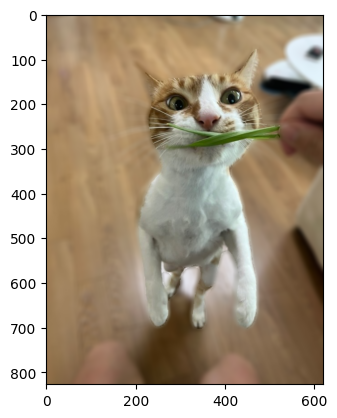

In [24]:
blur_cat = blur_image(cat_path, 'cat', False)
plt.imshow(cv2.cvtColor(blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

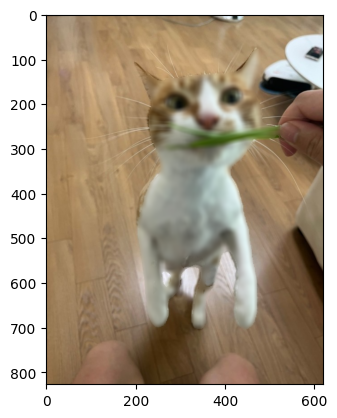

In [44]:
blur_cat = blur_image(cat_path, 'cat', True)
plt.imshow(cv2.cvtColor(blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

#### Chroma key test

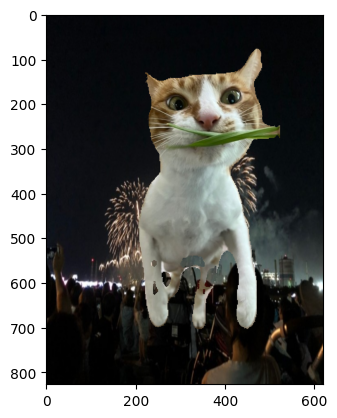

In [25]:
bg_path = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/background.jpeg'
blur_cat = blur_image(cat_path, 'cat', False, bg_path)
plt.imshow(cv2.cvtColor(blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

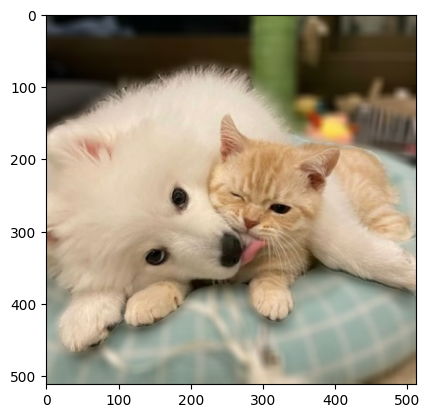

In [26]:
cat_dog_path = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/cat_dog.jpeg'
blur_cat_dog = blur_image(cat_dog_path, 'cat')
plt.imshow(cv2.cvtColor(blur_cat_dog, cv2.COLOR_BGR2RGB))
plt.show()

12
[ 0  8 12]


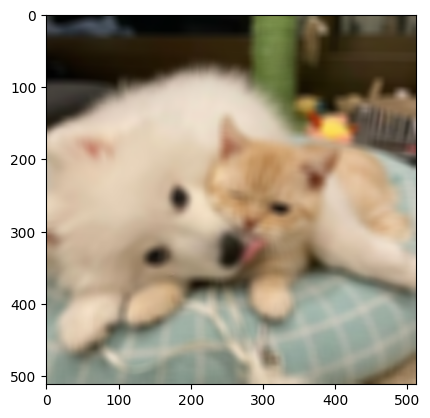

In [29]:
blur_dog_cat = blur_image(cat_dog_path, 'dog')
plt.imshow(cv2.cvtColor(blur_dog_cat, cv2.COLOR_BGR2RGB))
plt.show()

12
[ 0  8 12]


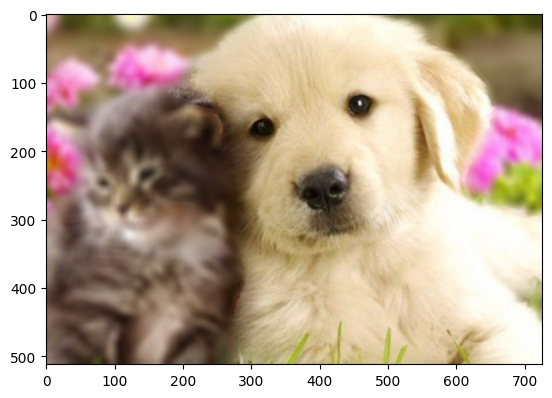

In [31]:
blur_cat_dog_diff = blur_image(os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/cat_dog_diff.jpeg', 'dog')
plt.imshow(cv2.cvtColor(blur_cat_dog_diff, cv2.COLOR_BGR2RGB))
plt.show()

8
[ 0  8 12]


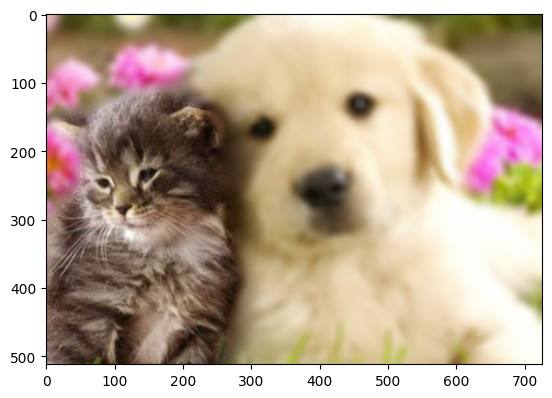

In [32]:
blur_cat_dog_diff = blur_image(os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/cat_dog_diff.jpeg', 'cat')
plt.imshow(cv2.cvtColor(blur_cat_dog_diff, cv2.COLOR_BGR2RGB))
plt.show()

### Step 2. Problems

#### 1. 고양이 사진
- 코드를 함수화하여 테스트한 실험
  ![prob_blur_cat.png](./images/prob_blur_cat.png)
  - 손은 잘 구분하여 분할된 듯 보임
  - 하지만 물고 있는 풀(?)은 인식을 못 한 듯
  - 그럭저럭 고양이를 잘 인식한 것으로 보임
- 사진에서 고양이를 크롭하고 어두운 색깔의 배경에 추가한 실험
  ![prob_cat.png](./images/prob_cat.png)
  - 배경을 흐릿하게 했던 것 보다 모델이 인식하지 못한 부분들을 쉽게 알 수 있었음
  - 다리에 구멍 뚫린 부분들이 많음
  - 고양이 얼굴을 중심적으로 모델이 특징을 학습하는 것으로 보임

#### 2. 강아지 고양이 사진
- 서로 다른 클라스의 객체들이 붙어 있는 경우를 실험
  ![prob_dog_cat_1.png](./images/prob_dog_cat_1.png)
  ![prob_dog_cat_2.png](./images/prob_dog_cat_2.png)
  - 모델에서 segvalues에 강아지가 인식된 걸로 보이나, 제대로 분할하지 못함
  - 색깔이 비슷해서 객체 간의 경계를 잘 구분 못 했을 것 같음
  - 강아지, 고양이 객체의 털 색깔이 반대되는 사진으로 실험하니 정상적으로 분할 가능

15
[ 0  8 15]


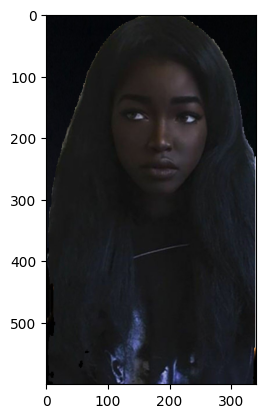

In [35]:
bg_path = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/background.jpeg'
blur_black_person = blur_image(os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/black_person.png', 'person', False, bg_path)
plt.imshow(cv2.cvtColor(blur_black_person, cv2.COLOR_BGR2RGB))
plt.show()

#### 3. 흑인 실험
- 정상적으로 인식하고 크로마키 가능

### Step 3. Solutions

#### 1. 사진을 샤프닝하면 엣지가 잘 인식되지 않을까?

In [36]:
def sharpen(image, amount=1.0, radius=1.0):
    # Create a sharpening filter kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]]) * amount

    # Image processing using filters
    sharpened = cv2.filter2D(image, -1, kernel)

    # Make sure the pixel value is between 0-255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened

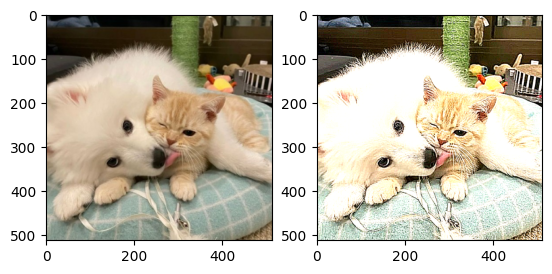

True

In [40]:
base_path = os.getenv('HOME')+'/testspace/aiffel/AIFFEL_quest_rs/Exploration/Ex04/images/'
cat_dog_path = base_path + 'cat_dog.jpeg'
cat_dog = cv2.imread(cat_dog_path)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cat_dog, cv2.COLOR_BGR2RGB))
sharpened_image = sharpen(cat_dog, amount=1.5, radius=3)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite(base_path + 'sharpened_cat_dog.jpg', sharpened_image)

12
[ 0  3  8 12]


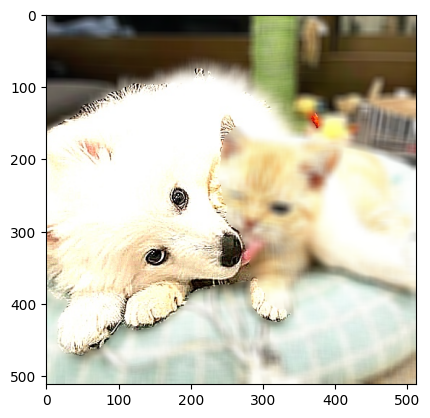

In [41]:
sharpened_dog_cat = blur_image(base_path + 'sharpened_cat_dog.jpg', 'dog')
plt.imshow(cv2.cvtColor(sharpened_dog_cat, cv2.COLOR_BGR2RGB))
plt.show()

- 확실히 전처리를 하기 전보다 인식되는 정확도는 높아진 듯
- 해당 마스크를 이용하여 원본에 블러링을 적용하면 될 듯

![prob_sharpening.png](./images/prob_sharpening.png)
- 하지만 고양이 발과 강아지 다리는 제대로 구분해내지는 못 하는 듯
- 각 객체의 얼굴 특징 정도만 잘 구분한 것으로 보임

#### 2. 엣지 위주로 남겨볼까?


In [49]:
def edge_sharpen(image, amount=1.0, radius=1.0):
    # Create a sharpening filter kernel
    kernel = np.array([[1,  1, 1],
                       [1, -7, 1],
                       [1,  1, 1]]) * amount

    # Image processing using filters
    sharpened = cv2.filter2D(image, -1, kernel)

    # Make sure the pixel value is between 0-255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened

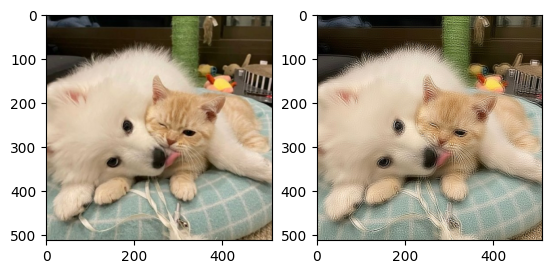

True

In [51]:
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cat_dog, cv2.COLOR_BGR2RGB))
edge_sharpened_image = edge_sharpen(cat_dog)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(edge_sharpened_image, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite(base_path + 'edge_sharpened_cat_dog.jpg', edge_sharpened_image)

In [52]:
edge_sharpened_dog_cat = blur_image(base_path + 'edge_sharpened_cat_dog.jpg', 'dog')
plt.imshow(cv2.cvtColor(edge_sharpened_dog_cat, cv2.COLOR_BGR2RGB))
plt.show()

12
[0 8]


Exception: Target index 12 not found in segvalues.

8
[0 8]


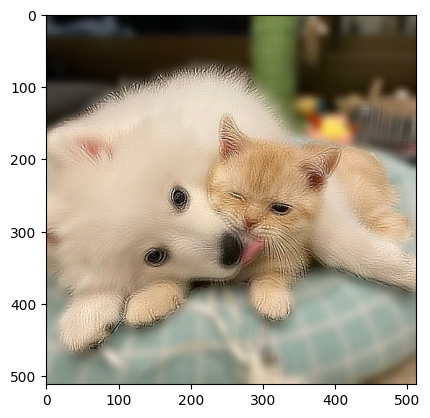

In [53]:
edge_sharpened_dog_cat = blur_image(base_path + 'edge_sharpened_cat_dog.jpg', 'cat')
plt.imshow(cv2.cvtColor(edge_sharpened_dog_cat, cv2.COLOR_BGR2RGB))
plt.show()

![prob_edge_sharpened.png](./images/prob_edge_sharpened.png)
- 이건 아예 개가 있는지도 모름

## 회고
### 여러 사진 테스트해보기
- 고양이 사진 : 고양이는 잘 감지되나, 분할은 잘 안 됨
- 비슷한 색깔의 강아지 고양이 사진 : 각 클래스는 인식이 되었지만, 분할하는 과정에서 문제가 발생
- 보색의 강아지 고양이 사진 : 각 클래스도 인식이 잘 되고, 분할도 잘 됨
- 흑인 사진 : 역시 이슈가 좀 있었던 부분이라 그런지, 모델이 잘 학습되어 있음

**분류를 하는 과정에서는 대부분 잘 동작하였으나, 분할하는 과정에서 오차가 좀 있었음**  
- 분류를 하는 것은 각 물체의 특성을 이해해서 있는지/없는지 정도의 단순 문제이지만
- 분할을 각 픽셀들에서 하나 하나 판단해야 하는 문제라 오차가 있는 것 같음
- 예를 들어, 샤프닝한 비슷한 털 색깔을 가진 고양이와 강아지 사진에서는,
  - 샤프닝을 통해 얼굴 부분에서는 특징이 뚜렷해졌을 것으로 예상됨
  - 하지만 몸통이나 발 같은 경우는 대게 비슷하다고 할 수 있어서.. 분할이 잘 안 된 것으로 보임

### 코드 작성
- 코드 작성할 때는 역시 오타가 문제!!! 오타!! 오타!!!!!!! ㅎ

### 종합적..
- 플랫폼이 잘 안 돼서 결국 로컬에 파이썬 3.7 설치해서 venv 환경 설정 완료
- 이제 macOS에서는 파이썬 3.7을 default로 지원하지 않나 봄
- DeepLab V3 논문을 보니 2016년에 처음 나오고 2만번 가량 cited
- 그 동안 기술이 발전하면서 좀 더 복잡한 세그멘테이션 트랜스포머 + 모델의 구조를 가지게 된 것 같음
- 역시 도메인 지식이 중요하지 않을까.. 생각됨